In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_file

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
data_date_and_time = '20190504034237'
data_files = get_data_files(data_date_and_time)
noise_files = [preceding_noise_file(f) for f in data_files]
cfg = CounterConfig(data_files, noise_files)
ckv = GetCkv(cfg)

Now let's simulate an event with given shower parameters.

In [3]:
corsika_file = '/home/isaac/NIZ/corsika/iact_DAT000011.dat'
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_ei(corsika_file)

/home/isaac/NIZ/niche_fit.py:83: RuntimeWarning: invalid value encountered in power
  lout[fl5] += pk*np.exp(-f5**(2+f5/2))


In [4]:
import CHASM as ch
ei = ch.EventioWrapper(corsika_file)
xmax = ei.X[ei.nch.argmax()]
nmax = ei.nch.max()
theta = ei.theta
phi = ei.phi
pars = [xmax,nmax,theta,phi,437., -660.,-29.0,0,70,128.02]
print(pars)

[529.0, 786003.9, 0.69254667, 1.2880529483133039, 437.0, -660.0, -29.0, 0, 70, 128.02]


In [5]:
from gen_ckv_signals import *
cor_out = read_in_corsika(corsika_file,cfg)
ev = BasicParams.get_event(pars)
ch_out = get_ckv(ev,cfg)

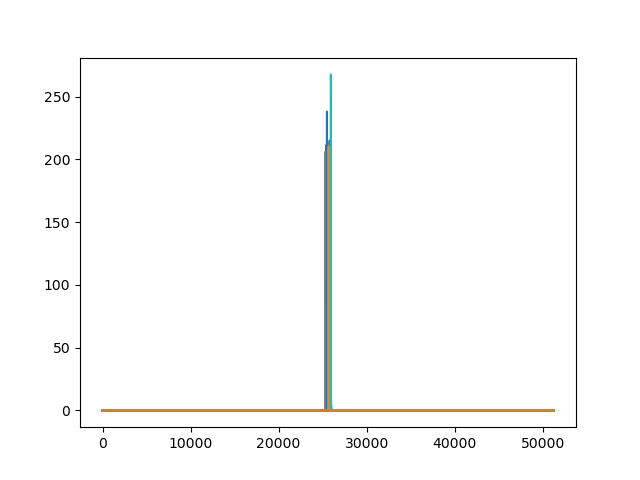

In [6]:
plt.figure()
for wf in cor_out.photons.sum(axis=1):
    plt.plot(wf)

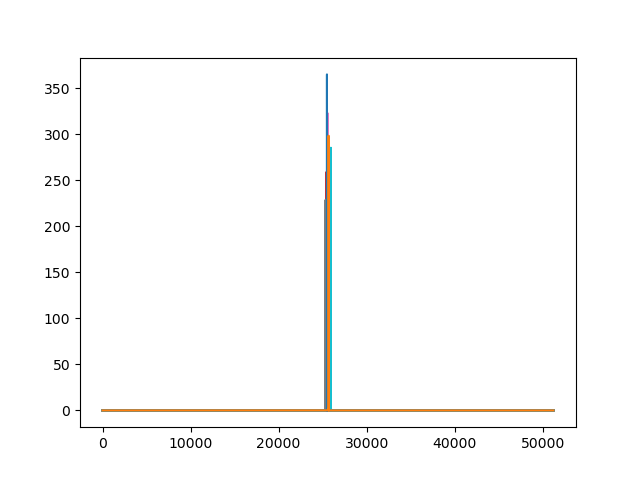

In [7]:
from trigger import *
plt.figure()
for wf,times in zip(ch_out.photons.sum(axis=1), ch_out.times):
    p,t = bin_photons(wf,times)
    plt.plot(p)

We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

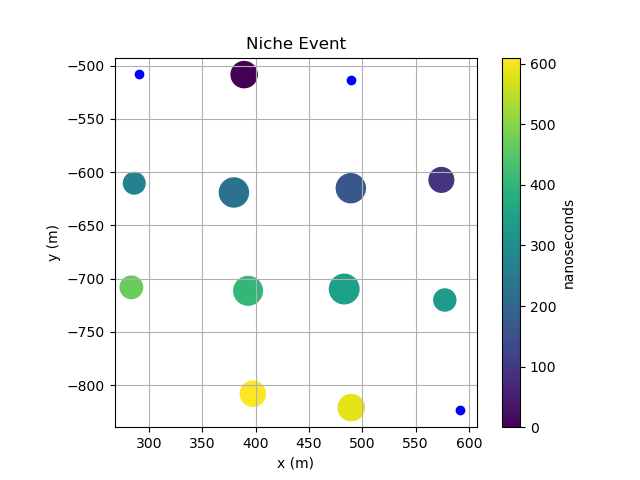

In [8]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [9]:
pf

20240327133739.000025559
bardeen curie dirac feynman meitner newton noether rossi rubin rutherford yukawa 
nx =  0.1711 ny =  0.6142 z0 =  -1.8
  +/- 0.0003   +/- 0.0003   +/-  0.0
  ( 7.21e-08  2.73e-09 -1.60e-06)
  ( 2.73e-09  8.37e-08 -3.51e-06)
  (-1.60e-06 -3.51e-06  7.72e-04)
th =  0.6914 ph =  1.2992

In [10]:
guess = make_guess(ty, pf,cfg)
for i,p in enumerate(guess):
    guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=529.0, limits=(400.0, 800.0), error=50.0, fixed=False)
FitParam(name='nmax', value=786003.9, limits=(10000.0, 100000000.0), error=100000.0, fixed=False)
FitParam(name='zenith', value=0.69254667, limits=(0.0, 0.7913703516775114), error=0.017453292519943295, fixed=False)
FitParam(name='azimuth', value=1.2880529483133039, limits=(1.1991943467265447, 1.3991943467265449), error=0.017453292519943295, fixed=False)
FitParam(name='corex', value=437.0, limits=(379.5, 489.2), error=5.0, fixed=False)
FitParam(name='corey', value=-660.0, limits=(-711.4, -615.1), error=5.0, fixed=False)
FitParam(name='corez', value=-29.0, limits=(-29.0, -29.0), error=1.0, fixed=True)
FitParam(name='x0', value=0, limits=(0, 0), error=1, fixed=True)
FitParam(name='lambda', value=70, limits=(70.0, 70.0), error=1, fixed=True)
FitParam(name='t_offset', value=128.02, limits=(-450.0, 450.0), error=10.0, fixed=False)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [11]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

In [12]:
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.486e+04 (χ²/ndof = 204.8)│              Nfcn = 130              │
│ EDM = 0.000754 (Goal: 0.0002)    │           time = 37.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    530    │    50     │            │            │   400   │   800   │  yes  │
│ 1 │ nmax     │  0.79e6   │  0.10e6   │            │            │  10000  │  1e+08  │  yes  │
│ 2 │ zenith   │   0.693   │   0.017   │            │            │    0    │ 0.79137 │  yes  │
│ 3 │ azimuth  │   1.288   │   0.017   │            │            │ 1.19919 │ 1.39919 │  yes  │
│ 4 │ corex    │    437    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -660    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │    -29    │     1     │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │  -189.73  │   0.16    │            │            │  -450   │   450   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │        0        0        0        0        0        0        0        0        0    0.000 │
│     nmax │        0        0        0        0        0        0        0        0        0    0.000 │
│   zenith │        0        0        0        0        0        0        0        0        0    0.000 │
│  azimuth │        0        0        0        0        0        0        0        0        0    0.000 │
│    corex │        0        0        0        0        0        0        0        0        0    0.000 │
│    corey │        0        0        0        0        0        0        0        0        0    0.000 │
│    corez │        0        0        0        0        0        0        0        0        0    0.000 │
│       x0 │        0        0        0        0        0        0        0        0        0    0.000 │
│   lambda │        0        0        0        0        0        0        0        0        0    0.000 │
│ t_offset │    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   0.0265 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
m.tol=.1
m.fixed = True
m.fixed['xmax'] = False
m.fixed['nmax'] = False
m.fixed['zenith'] = False
m.fixed['azimuth'] = False
m.fixed['corex'] = False
m.fixed['corey'] = False
m.fixed['t_offset'] = False

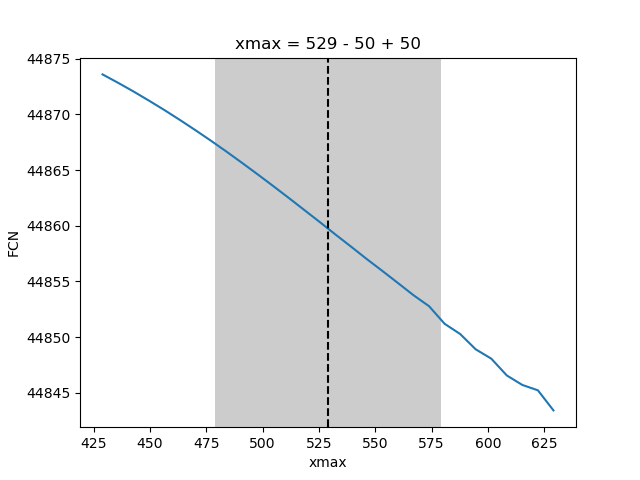

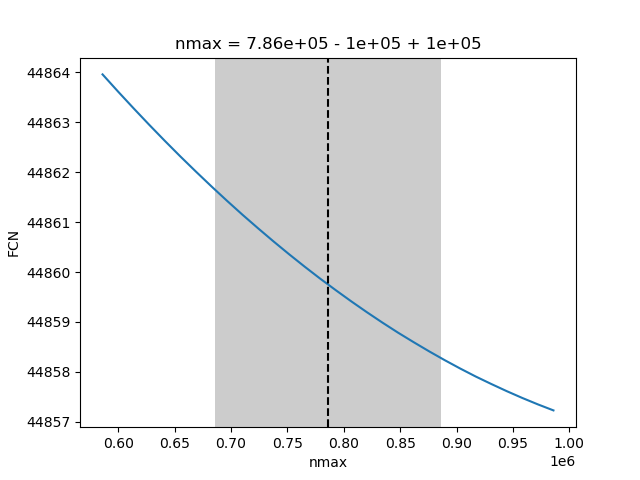

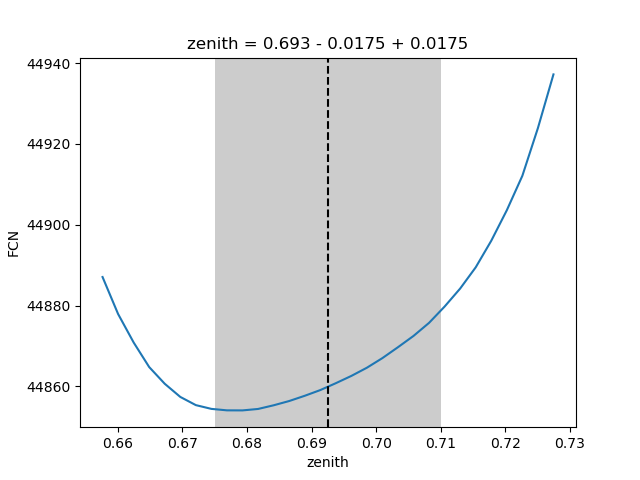

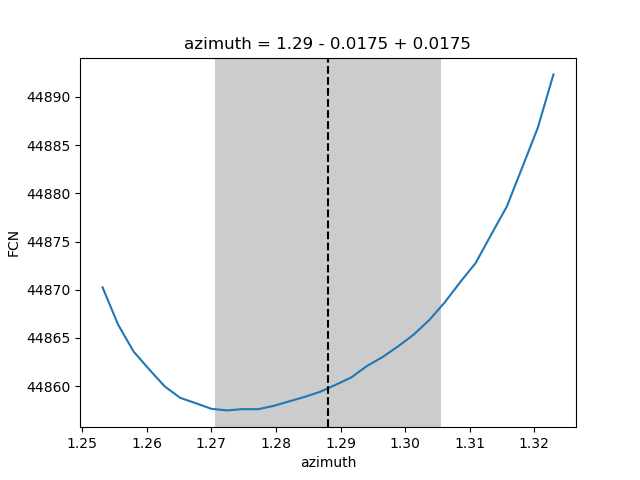

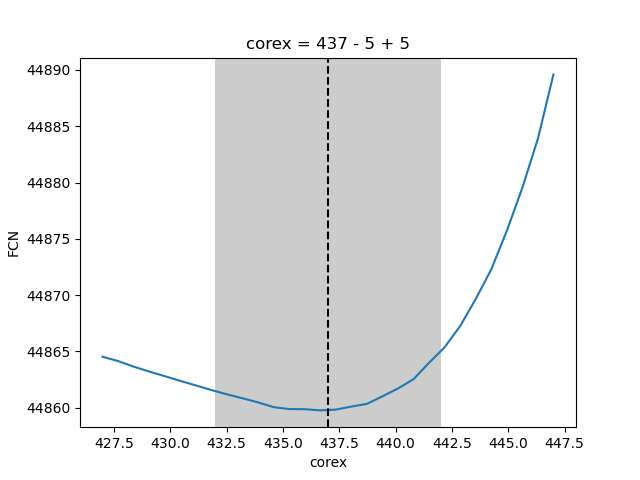

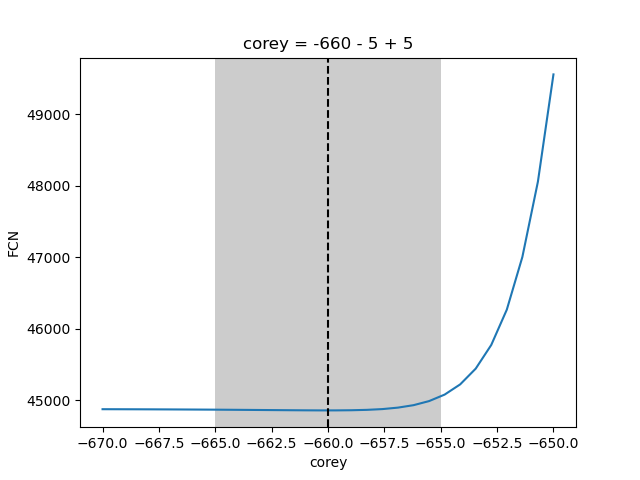

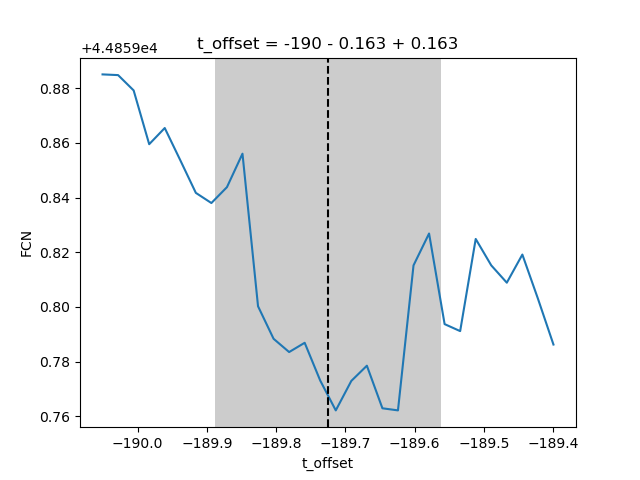

In [14]:
parnames = np.array([p.name for p in m.params])[~m.fixed]
for name in parnames:
    plt.figure()
    m.draw_profile(name, subtract_min=False, size = 30)
    # m.draw_profile(name, bound=m.limits[name], subtract_min=False)